In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling)
    conv3 = maxpool2d(conv3, k=2)
    print(conv3.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 2, 2, 64)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 210376.625000, Accuracy = 0.0120000001043
Performance on test set: Training epochs #1000, Batch Loss = 137299.359375, Accuracy = 0.0
Training epochs #20000: Batch Loss = 104380.507812, Accuracy = 0.126000002027
Performance on test set: Training epochs #20000, Batch Loss = 74367.015625, Accuracy = 0.0120000001043
Training epochs #40000: Batch Loss = 59589.414062, Accuracy = 0.0959999933839
Performance on test set: Training epochs #40000, Batch Loss = 38292.3671875, Accuracy = 0.0120000001043
Training epochs #60000: Batch Loss = 35873.851562, Accuracy = 0.366999983788
Performance on test set: Training epochs #60000, Batch Loss = 17293.4355469, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 24129.933594, Accuracy = 0.563000023365
Performance on test set: Training epochs #80000, Batch Loss = 16396.1796875, Accuracy = 0.805000007153
Training epochs #100000: Batch Loss = 83954.242188, Accuracy = 0.069000005722
Performance on test set: Train

Training epochs #920000: Batch Loss = 4973.084961, Accuracy = 0.694000005722
Performance on test set: Training epochs #920000, Batch Loss = 886.49609375, Accuracy = 0.942999958992
Training epochs #940000: Batch Loss = 3701.555908, Accuracy = 0.780000030994
Performance on test set: Training epochs #940000, Batch Loss = 1281.94226074, Accuracy = 0.943000018597
Training epochs #960000: Batch Loss = 2566.952393, Accuracy = 0.856000065804
Performance on test set: Training epochs #960000, Batch Loss = 1526.30029297, Accuracy = 0.943000078201
Training epochs #980000: Batch Loss = 24095.033203, Accuracy = 0.259000003338
Performance on test set: Training epochs #980000, Batch Loss = 907.453918457, Accuracy = 0.943000018597
Training epochs #1000000: Batch Loss = 4670.684082, Accuracy = 0.696999967098
Performance on test set: Training epochs #1000000, Batch Loss = 816.274475098, Accuracy = 0.942999958992
Training epochs #1020000: Batch Loss = 3294.093018, Accuracy = 0.791000008583
Performance on 

Training epochs #1820000: Batch Loss = 1831.701782, Accuracy = 0.856000065804
Performance on test set: Training epochs #1820000, Batch Loss = 554.08605957, Accuracy = 0.954999983311
Training epochs #1840000: Batch Loss = 1154.202393, Accuracy = 0.894999980927
Performance on test set: Training epochs #1840000, Batch Loss = 656.800231934, Accuracy = 0.955000042915
Training epochs #1860000: Batch Loss = 12896.666992, Accuracy = 0.339000016451
Performance on test set: Training epochs #1860000, Batch Loss = 392.080657959, Accuracy = 0.961000025272
Training epochs #1880000: Batch Loss = 2263.234131, Accuracy = 0.786000072956
Performance on test set: Training epochs #1880000, Batch Loss = 373.161621094, Accuracy = 0.961000084877
Training epochs #1900000: Batch Loss = 1821.397949, Accuracy = 0.844999969006
Performance on test set: Training epochs #1900000, Batch Loss = 522.820800781, Accuracy = 0.955000042915
Training epochs #1920000: Batch Loss = 1026.814941, Accuracy = 0.90600001812
Performa

Training epochs #2720000: Batch Loss = 497.101654, Accuracy = 0.922000050545
Performance on test set: Training epochs #2720000, Batch Loss = 371.153778076, Accuracy = 0.961000025272
Training epochs #2740000: Batch Loss = 8309.833984, Accuracy = 0.419000029564
Performance on test set: Training epochs #2740000, Batch Loss = 215.99508667, Accuracy = 0.961000025272
Training epochs #2760000: Batch Loss = 1101.153809, Accuracy = 0.861999988556
Performance on test set: Training epochs #2760000, Batch Loss = 227.072402954, Accuracy = 0.961000084877
Training epochs #2780000: Batch Loss = 926.543823, Accuracy = 0.897000014782
Performance on test set: Training epochs #2780000, Batch Loss = 322.046875, Accuracy = 0.961000025272
Training epochs #2800000: Batch Loss = 656.119263, Accuracy = 0.92300003767
Performance on test set: Training epochs #2800000, Batch Loss = 357.428985596, Accuracy = 0.961000025272
Training epochs #2820000: Batch Loss = 7231.483887, Accuracy = 0.446000009775
Performance on 

Training epochs #3640000: Batch Loss = 731.628357, Accuracy = 0.896000027657
Performance on test set: Training epochs #3640000, Batch Loss = 116.762886047, Accuracy = 0.982000112534
Training epochs #3660000: Batch Loss = 426.011047, Accuracy = 0.921000063419
Performance on test set: Training epochs #3660000, Batch Loss = 178.590621948, Accuracy = 0.961000025272
Training epochs #3680000: Batch Loss = 368.880280, Accuracy = 0.947000086308
Performance on test set: Training epochs #3680000, Batch Loss = 201.033493042, Accuracy = 0.961000084877
Training epochs #3700000: Batch Loss = 4109.023438, Accuracy = 0.560000002384
Performance on test set: Training epochs #3700000, Batch Loss = 116.457794189, Accuracy = 0.982000052929
Training epochs #3720000: Batch Loss = 603.782166, Accuracy = 0.887000024319
Performance on test set: Training epochs #3720000, Batch Loss = 112.037834167, Accuracy = 0.982000052929
Training epochs #3740000: Batch Loss = 521.132263, Accuracy = 0.925000071526
Performance 

Training epochs #4540000: Batch Loss = 339.340179, Accuracy = 0.934000074863
Performance on test set: Training epochs #4540000, Batch Loss = 83.9935379028, Accuracy = 0.974999964237
Training epochs #4560000: Batch Loss = 237.017715, Accuracy = 0.956000030041
Performance on test set: Training epochs #4560000, Batch Loss = 98.2741546631, Accuracy = 0.974999964237
Training epochs #4580000: Batch Loss = 2707.358887, Accuracy = 0.634000003338
Performance on test set: Training epochs #4580000, Batch Loss = 74.2648544312, Accuracy = 0.983000040054
Training epochs #4600000: Batch Loss = 347.333862, Accuracy = 0.930999994278
Performance on test set: Training epochs #4600000, Batch Loss = 73.4175949097, Accuracy = 0.983000040054
Training epochs #4620000: Batch Loss = 463.369232, Accuracy = 0.944999992847
Performance on test set: Training epochs #4620000, Batch Loss = 80.8538513184, Accuracy = 0.982000052929
Training epochs #4640000: Batch Loss = 151.589233, Accuracy = 0.958999991417
Performance 

Training epochs #5460000: Batch Loss = 1563.004883, Accuracy = 0.710000038147
Performance on test set: Training epochs #5460000, Batch Loss = 50.7550239563, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 247.881653, Accuracy = 0.93599998951
Performance on test set: Training epochs #5480000, Batch Loss = 52.3147697449, Accuracy = 0.990999996662
Training epochs #5500000: Batch Loss = 132.797256, Accuracy = 0.964000105858
Performance on test set: Training epochs #5500000, Batch Loss = 49.2038650513, Accuracy = 0.982000052929
Training epochs #5520000: Batch Loss = 174.129150, Accuracy = 0.962000012398
Performance on test set: Training epochs #5520000, Batch Loss = 52.7161636353, Accuracy = 0.981999993324
Training epochs #5540000: Batch Loss = 1762.494263, Accuracy = 0.699000000954
Performance on test set: Training epochs #5540000, Batch Loss = 48.9965286255, Accuracy = 0.991000056267
Training epochs #5560000: Batch Loss = 179.135590, Accuracy = 0.93900001049
Performance o

Training epochs #6380000: Batch Loss = 114.331825, Accuracy = 0.964999973774
Performance on test set: Training epochs #6380000, Batch Loss = 26.8148593903, Accuracy = 0.990000069141
Training epochs #6400000: Batch Loss = 70.810577, Accuracy = 0.976999998093
Performance on test set: Training epochs #6400000, Batch Loss = 25.3020553589, Accuracy = 0.983000040054
Training epochs #6420000: Batch Loss = 1076.780884, Accuracy = 0.744000017643
Performance on test set: Training epochs #6420000, Batch Loss = 35.7234153748, Accuracy = 0.991000056267
Training epochs #6440000: Batch Loss = 155.702927, Accuracy = 0.957000017166
Performance on test set: Training epochs #6440000, Batch Loss = 36.1131324768, Accuracy = 0.991000056267
Training epochs #6460000: Batch Loss = 121.921631, Accuracy = 0.969000041485
Performance on test set: Training epochs #6460000, Batch Loss = 26.5684299469, Accuracy = 0.990000009537
Training epochs #6480000: Batch Loss = 28.462156, Accuracy = 0.987999975681
Performance on

Training epochs #7300000: Batch Loss = 699.489807, Accuracy = 0.787999987602
Performance on test set: Training epochs #7300000, Batch Loss = 24.2520465851, Accuracy = 0.991000056267
Training epochs #7320000: Batch Loss = 97.222900, Accuracy = 0.965000033379
Performance on test set: Training epochs #7320000, Batch Loss = 26.1930770874, Accuracy = 0.990999996662
Training epochs #7340000: Batch Loss = 55.828587, Accuracy = 0.983000040054
Performance on test set: Training epochs #7340000, Batch Loss = 17.6554298401, Accuracy = 0.991000056267
Training epochs #7360000: Batch Loss = 19.528952, Accuracy = 0.986000061035
Performance on test set: Training epochs #7360000, Batch Loss = 13.4010486603, Accuracy = 0.991000115871
Training epochs #7380000: Batch Loss = 765.494629, Accuracy = 0.791000068188
Performance on test set: Training epochs #7380000, Batch Loss = 21.3775253296, Accuracy = 0.991000056267
Training epochs #7400000: Batch Loss = 72.074409, Accuracy = 0.970000088215
Performance on te

Training epochs #8220000: Batch Loss = 39.756966, Accuracy = 0.980000078678
Performance on test set: Training epochs #8220000, Batch Loss = 6.0375161171, Accuracy = 0.991000056267
Training epochs #8240000: Batch Loss = 6.657116, Accuracy = 0.991000056267
Performance on test set: Training epochs #8240000, Batch Loss = 2.20623803139, Accuracy = 0.991000056267
Training epochs #8260000: Batch Loss = 494.691315, Accuracy = 0.830000042915
Performance on test set: Training epochs #8260000, Batch Loss = 13.682261467, Accuracy = 0.991000056267
Training epochs #8280000: Batch Loss = 37.147858, Accuracy = 0.980999946594
Performance on test set: Training epochs #8280000, Batch Loss = 14.9558448792, Accuracy = 0.991000056267
Training epochs #8300000: Batch Loss = 58.761940, Accuracy = 0.983000040054
Performance on test set: Training epochs #8300000, Batch Loss = 6.88139438629, Accuracy = 0.990999996662
Training epochs #8320000: Batch Loss = 16.254717, Accuracy = 0.995000064373
Performance on test s

Training epochs #9140000: Batch Loss = 253.751740, Accuracy = 0.87700009346
Performance on test set: Training epochs #9140000, Batch Loss = 4.04066848755, Accuracy = 0.991000115871
Training epochs #9160000: Batch Loss = 29.678543, Accuracy = 0.982000052929
Performance on test set: Training epochs #9160000, Batch Loss = 7.086124897, Accuracy = 0.991000056267
Training epochs #9180000: Batch Loss = 22.683540, Accuracy = 0.983999967575
Performance on test set: Training epochs #9180000, Batch Loss = 0.761456608772, Accuracy = 0.996999979019
Training epochs #9200000: Batch Loss = 11.509359, Accuracy = 0.992000043392
Performance on test set: Training epochs #9200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9220000: Batch Loss = 260.149292, Accuracy = 0.883000016212
Performance on test set: Training epochs #9220000, Batch Loss = 2.5564558506, Accuracy = 0.991000056267
Training epochs #9240000: Batch Loss = 17.584280, Accuracy = 0.987999975681
Performance on test set: Traini

Training epochs #10080000: Batch Loss = 6.317296, Accuracy = 0.996000051498
Performance on test set: Training epochs #10080000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #10100000: Batch Loss = 207.651459, Accuracy = 0.898999989033
Performance on test set: Training epochs #10100000, Batch Loss = 0.1668471843, Accuracy = 0.996999979019
Training epochs #10120000: Batch Loss = 54.001545, Accuracy = 0.987000107765
Performance on test set: Training epochs #10120000, Batch Loss = 1.23299705982, Accuracy = 0.996999979019
Training epochs #10140000: Batch Loss = 12.268378, Accuracy = 0.990000009537
Performance on test set: Training epochs #10140000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #10160000: Batch Loss = 5.625391, Accuracy = 0.995000064373
Performance on test set: Training epochs #10160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10180000: Batch Loss = 146.822968, Accuracy = 0.897000074387
Performance on test set: Training epochs #10180000, Batch Loss

Training epochs #11040000: Batch Loss = 5.811953, Accuracy = 0.991999983788
Performance on test set: Training epochs #11040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11060000: Batch Loss = 113.777306, Accuracy = 0.916000008583
Performance on test set: Training epochs #11060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11080000: Batch Loss = 7.933816, Accuracy = 0.990000009537
Performance on test set: Training epochs #11080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11100000: Batch Loss = 7.648380, Accuracy = 0.991000056267
Performance on test set: Training epochs #11100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11120000: Batch Loss = 2.549773, Accuracy = 0.995000004768
Performance on test set: Training epochs #11120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11140000: Batch Loss = 95.575195, Accuracy = 0.928000032902
Performance on test set: Training epochs #11140000, Batch Loss = 0

Training epochs #12000000: Batch Loss = 0.418472, Accuracy = 0.999000072479
Performance on test set: Training epochs #12000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12020000: Batch Loss = 73.910690, Accuracy = 0.944999992847
Performance on test set: Training epochs #12020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12040000: Batch Loss = 3.793398, Accuracy = 0.995999991894
Performance on test set: Training epochs #12040000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #12060000: Batch Loss = 8.591893, Accuracy = 0.993999958038
Performance on test set: Training epochs #12060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12080000: Batch Loss = 3.356669, Accuracy = 0.997000038624
Performance on test set: Training epochs #12080000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12100000: Batch Loss = 98.222588, Accuracy = 0.922000050545
Performance on test set: Training epochs #12100000, Batch Loss = 0.0, Accurac

Training epochs #12980000: Batch Loss = 34.632687, Accuracy = 0.944000065327
Performance on test set: Training epochs #12980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13000000: Batch Loss = 3.364654, Accuracy = 0.994000077248
Performance on test set: Training epochs #13000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13020000: Batch Loss = 2.630684, Accuracy = 0.995000004768
Performance on test set: Training epochs #13020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13040000: Batch Loss = 0.478657, Accuracy = 0.999000072479
Performance on test set: Training epochs #13040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13060000: Batch Loss = 37.395321, Accuracy = 0.945000052452
Performance on test set: Training epochs #13060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13080000: Batch Loss = 2.351364, Accuracy = 0.996000051498
Performance on test set: Training epochs #13080000, Batch Loss = 0.

Training epochs #13960000: Batch Loss = 1.147528, Accuracy = 0.995999991894
Performance on test set: Training epochs #13960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13980000: Batch Loss = 2.169646, Accuracy = 0.995000064373
Performance on test set: Training epochs #13980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14000000: Batch Loss = 0.497438, Accuracy = 0.998000085354
Performance on test set: Training epochs #14000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14020000: Batch Loss = 24.254267, Accuracy = 0.968000113964
Performance on test set: Training epochs #14020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14040000: Batch Loss = 0.519246, Accuracy = 0.998000025749
Performance on test set: Training epochs #14040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14060000: Batch Loss = 1.466894, Accuracy = 0.995000004768
Performance on test set: Training epochs #14060000, Batch Loss = 0.0

Training epochs #14920000: Batch Loss = 3.152173, Accuracy = 0.994000017643
Performance on test set: Training epochs #14920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14940000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14960000: Batch Loss = 0.442886, Accuracy = 0.998000025749
Performance on test set: Training epochs #14960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14980000: Batch Loss = 13.106167, Accuracy = 0.979000031948
Performance on test set: Training epochs #14980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15000000: Batch Loss = 0.422620, Accuracy = 0.997000098228
Performance on test set: Training epochs #15000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15020000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15020000, Batch Loss = 0.0, 

Training epochs #15900000: Batch Loss = 0.360445, Accuracy = 0.999000072479
Performance on test set: Training epochs #15900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15920000: Batch Loss = 0.000004, Accuracy = 1.0
Performance on test set: Training epochs #15920000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15940000: Batch Loss = 12.524881, Accuracy = 0.976000070572
Performance on test set: Training epochs #15940000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15960000: Batch Loss = 2.065965, Accuracy = 0.997000038624
Performance on test set: Training epochs #15960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15980000: Batch Loss = 0.095164, Accuracy = 0.999000072479
Performance on test set: Training epochs #15980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #16000000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #16000000, Batch Loss = 0.0, Accuracy = 1.0000001

# performance visualization

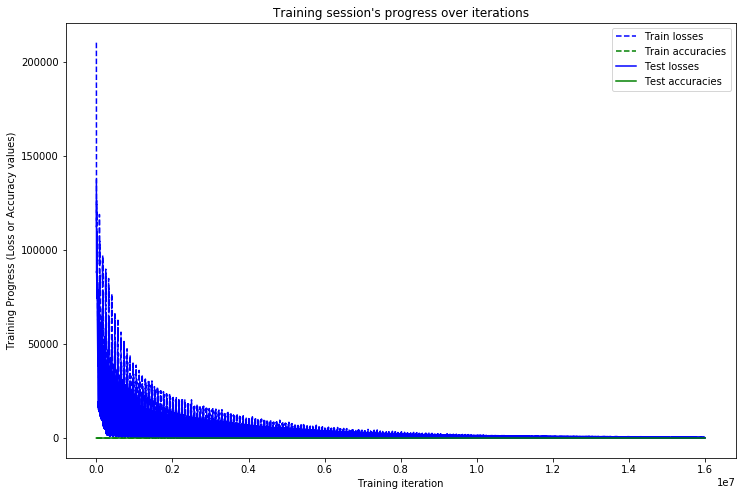

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.6350088754%
Recall: 97.77%
f1_score: 97.6807676914%

Confusion Matrix:
[[    0    18     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   794     7     0    27    27     0    46     0     0     0    10
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    10     0     0  2866     0     0    12     0     0     0     3
      0]
 [    0    67     0     0     2   266     0    13     0     0     0     0
      0]
 [    0     5     0     0     0     3 14486     0     0     0     0     1
      0]
 [    0    58    12     0    44    21     0   396     0     0     0     4
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     2     0     0     2     0     0
      0]
 [    0     0     0     0     0     0     0   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


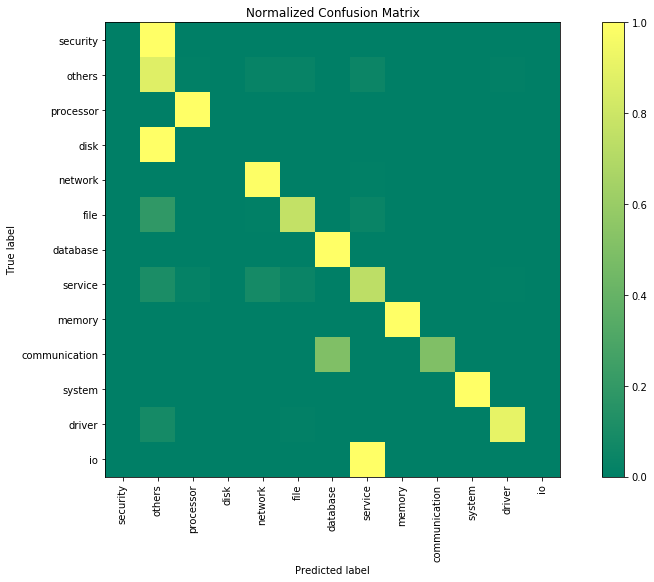

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)